# Spotify EDA
Seth Billiau, William Drew, Sarah Lucioni


We will explore the Spotify data using the Spotify API through the Spotipy library. We aim to find out what data we are working with and how we can predict a playlist from minimal user input.

In [19]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pickle

# import tensorflow as tf

# print(tf.__version__)  # You should see a 2.0.0 here!

## Clean Data

First, we need to clean our data. To use the Spotify API, having just the URI is much more useful then having extra characters appended to the URI. For this reason, we will clean these extra strings from our data. 

In [4]:
# remove "spotify:track:", "spotify:artist:", and "spotify:album:" from uri
def clean_data(i):
    df = pd.read_csv('Songs/songs' + str(i) + '.csv')
    df["track_uri"] = df["track_uri"].str[14:]
    df["artist_uri"] = df["artist_uri"].str[15:]
    df["album_uri"] = df["album_uri"].str[14:]
    return df

df = clean_data(0)

In [5]:
# Look to see if data is cleaned
df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,0,1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,Toxic,0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,0,2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,Crazy In Love,25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,0,3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,Rock Your Body,6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,0,4,Shaggy,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


## Access Spotify API

Now, we will access the Spotify API. We need to set our API keys and set up authentication with the API.

In [6]:
# https://stackoverflow.com/questions/30557409/spotify-api-post-call-response-415
# Spotify API keys
client_id = "9cd3dd2ea2cf492ca28ab0247a79d781"
client_secret = "11c972ad002843e9be5ecc31f022dd6e"
grant_type = 'client_credentials'
body_params = {'grant_type' : grant_type}
url = 'https://accounts.spotify.com/api/token'

response = requests.post(url, data=body_params, auth = (client_id, client_secret)) 
print(response.content)

b'{"access_token":"BQDb0CGEM-Q2C38F3F8efluxvQr_BrDBvrbbNdG2cxvYtUc9Y-T7yk_8eXZCAgcSknB_2zjoRZKTTMHKxUs","token_type":"Bearer","expires_in":3600,"scope":""}'


Now, let's check to see if we can access the audio features of a song via the track_uri.

In [7]:

# Using Spotipy library
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp.audio_features(["0UaMYEvWZi0ZqiDOoHU3YI"])

[{'danceability': 0.904,
  'energy': 0.813,
  'key': 4,
  'loudness': -7.105,
  'mode': 0,
  'speechiness': 0.121,
  'acousticness': 0.0311,
  'instrumentalness': 0.00697,
  'liveness': 0.0471,
  'valence': 0.81,
  'tempo': 125.461,
  'type': 'audio_features',
  'id': '0UaMYEvWZi0ZqiDOoHU3YI',
  'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
  'duration_ms': 226864,
  'time_signature': 4}]

## Add helpful functions

Let's add some helpful functions to explore the data. This includes extracting the songs via track_uri from each playlist and find the mean of the audio_features for a playlist.

In [8]:
def songs_in_playlist(df, pid):
    '''
    input: dataframe and playlist ID
    returns: list of all songs on playlist by track_uri 
    '''
    playlist = np.where(df.pid == pid)
    return list(df.iloc[playlist]["track_uri"])

def playlist_means(tracks):
    '''
    input: list of tracks on a playlist (can be generated from songs_in_playlist())
    returns: statistics for audio features of playlist  
    '''
    num = len(tracks)
    # We can only pass 100 tracks at a time
    if num <= 100:
        p = pd.DataFrame.from_records(list(filter(None, sp.audio_features(tracks))))
    else:
        start = 0
        end = 100
        p = pd.DataFrame.from_records(sp.audio_features(tracks[start:end]))
        for i in range(int(num / 100) - 1):
            start = end
            diff = num - end
            if diff > 100:
                end += 100
            else:
                end += diff
            
            new_p = pd.DataFrame.from_records(sp.audio_features(tracks[start:end]))
            p = p.append(new_p) 
    return p.describe()

In [9]:
# Testing the functionality of the above functions
tracks = songs_in_playlist(df, 42)
playlist_means(tracks)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.164437,0.606410,209502.380000,0.754760,0.000218,5.6200,0.197846,-5.37197,0.860000,0.070291,130.822820,3.990000,0.616044
std,0.188125,0.115716,27807.731746,0.147454,0.001073,3.7194,0.151993,1.79689,0.348735,0.059517,30.778824,0.173787,0.215203
min,0.001240,0.254000,142212.000000,0.268000,0.000000,0.0000,0.023800,-14.37300,0.000000,0.026600,74.142000,3.000000,0.096400
25%,0.030375,0.531500,190183.500000,0.683000,0.000000,2.0000,0.089425,-6.03400,1.000000,0.037675,105.009000,4.000000,0.471000
50%,0.079150,0.592500,207799.500000,0.780000,0.000000,6.0000,0.148500,-5.23900,1.000000,0.048750,127.496500,4.000000,0.641000
75%,0.240250,0.705750,225495.000000,0.856250,0.000001,9.0000,0.297500,-4.08175,1.000000,0.078375,153.926000,4.000000,0.780000
max,0.868000,0.863000,298641.000000,0.963000,0.008470,11.0000,0.968000,-2.45700,1.000000,0.438000,205.903000,5.000000,0.964000


## Visualization

The function below will iterate through our data and collect useful information which we will later visualize to add to our EDA. We only need to run this cell once because we will save the data in pickle files so that we don't have to run through all of the data again and again. Furthermore, we are visualizing on all of the data because we are not certain how we will split our data into train and test.

In [10]:
RAN = True
if not RAN:
    # Playlist length num of songs
    # Playlist length duration
    playlist_lengths = []
    playlist_durations = []

    song_counter = {}
    song_to_uri = {}

    artist_counter = {}
    artist_to_uri = {}

    album_counter = {}
    album_to_uri = {}
    for i in range(1000):
        df = clean_data(i)
        for j in range(1000):
            playlist = np.where(df.pid == j)
            tracks = list(df.iloc[playlist]["track_uri"])
            duration = sum(list(df.iloc[playlist]["duration_ms"]))

            playlist_lengths.append(len(tracks))
            playlist_durations.append(duration)

            # Find most popular songs
            tracks_name = list(df.iloc[playlist]["track_name"])
            for index, track in enumerate(tracks_name):
                if track in song_counter:
                    song_counter[track] += 1
                else:
                    song_counter[track] = 1
                    # Create a dictionary between song names and their URI
                    song_to_uri[track] = tracks[index]

            # Find most popular artist
            artist_name = list(df.iloc[playlist]["artist_name"])
            artists = list(df.iloc[playlist]["artist_uri"])
            for index, artist in enumerate(artist_name):
                if artist in artist_counter:
                    artist_counter[artist] += 1
                else:
                    artist_counter[artist] = 1
                    # Create a dictionary between artist names and their URI
                    artist_to_uri[artist] = artists[index]

            # Find most popular album
            album_name = list(df.iloc[playlist]["album_name"])
            albums = list(df.iloc[playlist]["album_uri"])
            for index, album in enumerate(album_name):
                if album in album_counter:
                    album_counter[album] += 1
                else:
                    album_counter[album] = 1
                    # Create a dictionary between artist names and their URI
                    album_to_uri[album] = albums[index]

    # RAN ONCE, DON'T RUN AGAIN. LOAD THE PICKLE FILES INSTEAD

In [11]:
if not RAN:
    # Sort song, artist, album by most occurrences before pickling
    sorted_songs = sorted(song_counter.items(), key=lambda x: x[1], reverse=True)
    sorted_artist = sorted(artist_counter.items(), key=lambda x: x[1], reverse=True)
    sorted_album = sorted(album_counter.items(), key=lambda x: x[1], reverse=True)

In [12]:
# Write playlist_lengths and playlist_durations to a pickle so we don't have to run everything again
# https://pythontips.com/2013/08/02/what-is-pickle-in-python/
def pickle_obj(filename, obj):
    fileObj = open(filename, 'wb')
    pickle.dump(obj, fileObj)
    fileObj.close()
    
# Write objects to pickle files
# pickle_obj('playlist_lengths', playlist_lengths)

# pickle_obj('playlist_durations', playlist_durations)

# pickle_obj('song_counter', song_counter)

# pickle_obj('sorted_songs', sorted_songs)

# pickle_obj('song_to_uri', song_to_uri)

# pickle_obj('artist_counter', artist_counter)

# pickle_obj('sorted_artist', sorted_artist)

# pickle_obj('artist_to_uri', artist_to_uri)

# pickle_obj('album_counter', album_counter)

# pickle_obj('sorted_album', sorted_album)

# pickle_obj('album_to_uri', album_to_uri)

# Uncomment if you want to read the pickle
fileObj = open('pickle_files/playlist_lengths', 'rb')
playlist_lengths = pickle.load(fileObj)

fileObj = open('pickle_files/playlist_durations', 'rb')
playlist_durations = pickle.load(fileObj)

fileObj = open('pickle_files/song_counter', 'rb')
song_counter = pickle.load(fileObj)

fileObj = open('pickle_files/sorted_songs', 'rb')
sorted_songs = pickle.load(fileObj)

fileObj = open('pickle_files/song_to_uri', 'rb')
song_to_uri = pickle.load(fileObj)

fileObj = open('pickle_files/artist_counter', 'rb')
artist_counter = pickle.load(fileObj)

fileObj = open('pickle_files/sorted_artist', 'rb')
sorted_artist = pickle.load(fileObj)

fileObj = open('pickle_files/artist_to_uri', 'rb')
artist_to_uri = pickle.load(fileObj)

fileObj = open('pickle_files/album_counter', 'rb')
album_counter = pickle.load(fileObj)

fileObj = open('pickle_files/sorted_album', 'rb')
sorted_album = pickle.load(fileObj)

fileObj = open('pickle_files/album_to_uri', 'rb')
album_to_uri = pickle.load(fileObj)

Time to plot the above data!

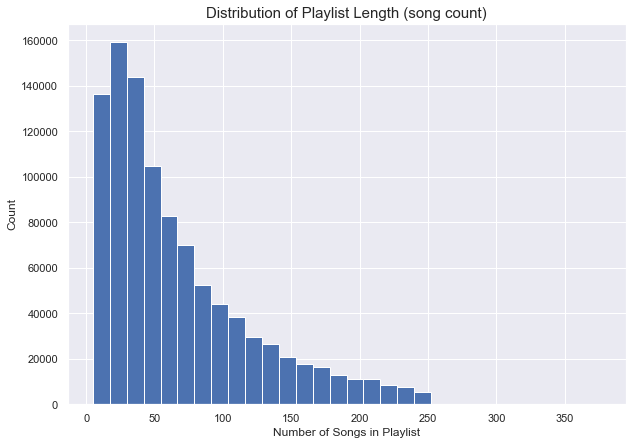

In [13]:
plt.figure(figsize=(10,7))
plt.hist(playlist_lengths, bins=30)
plt.xlabel("Number of Songs in Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Length (song count)", size=15)
plt.show()

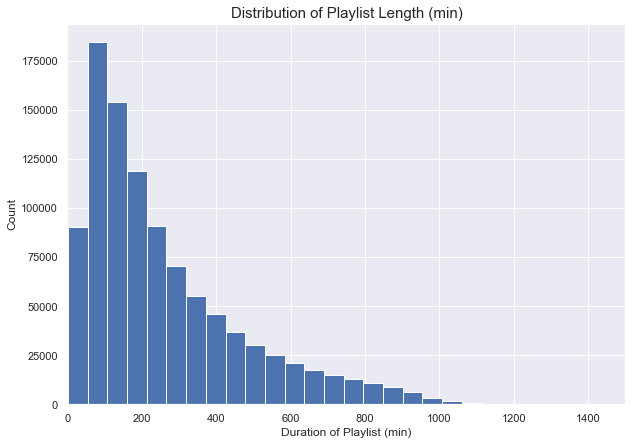

In [14]:
plt.figure(figsize=(10,7))
playlist_durations_min = np.asarray(playlist_durations)/60000
plt.hist(playlist_durations_min, bins=200)
plt.xlim(0,1500)
plt.xlabel("Duration of Playlist (min)")
plt.ylabel("Count")
plt.title("Distribution of Playlist Length (min)", size=15)
plt.show()

In [15]:
def summary_stats(arr):
    print("mean: ", np.mean(arr))
    print("std: ", np.std(arr))
    print("median: ", np.median(arr))
    print("max: ", np.max(arr))
    print("min: ", np.min(arr))
     
print("Playlist song count statistics (songs)")
print("----------------------------")
summary_stats(playlist_lengths)


print("\nPlaylist duration statistics (mins)")
print("----------------------------")
summary_stats(playlist_durations_min)

Playlist song count statistics (songs)
----------------------------
mean:  66.346428
std:  53.66933116446316
median:  49.0
max:  376
min:  5

Playlist duration statistics (mins)
----------------------------
mean:  259.66128071163337
std:  214.27380245241304
median:  190.37396666666666
max:  10584.5632
min:  1.6256333333333333


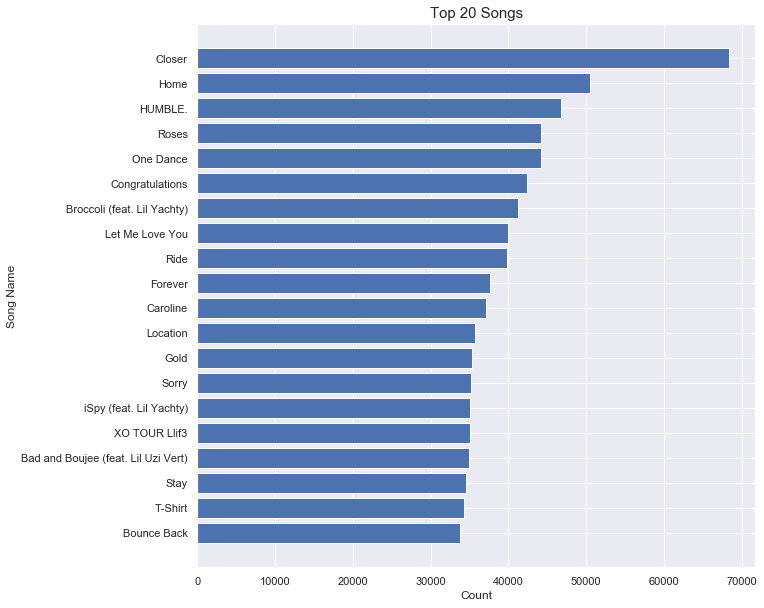

In [16]:
plt.figure(figsize=(10,10))
topSongs = sorted_songs[:20]
topSongs.reverse()
topSongs_names = [x[0] for x in topSongs]
numbered = np.arange(len(topSongs_names))
topSongs_values = [x[1] for x in topSongs]
plt.barh(numbered, topSongs_values, align='center')
plt.yticks(numbered, topSongs_names)
plt.xlabel("Count")
plt.ylabel("Song Name")
plt.title("Top 20 Songs", size=15)
plt.show()

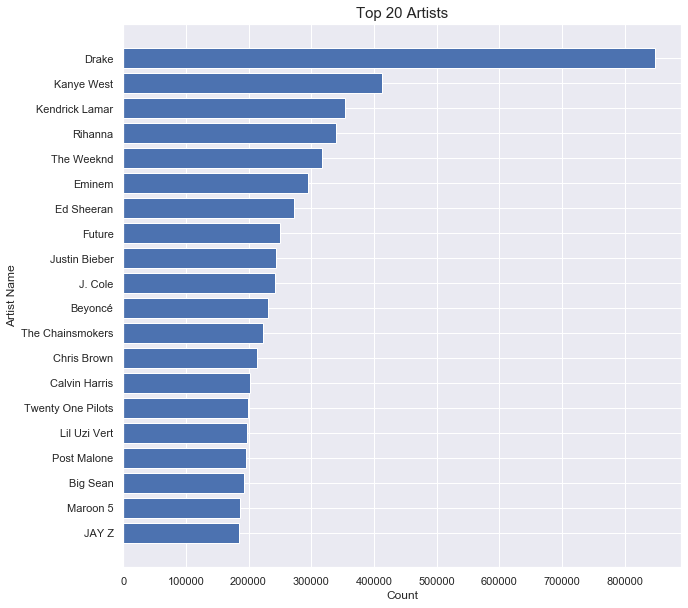

In [17]:
plt.figure(figsize=(10,10))
topArtists = sorted_artist[:20]
topArtists.reverse()
topArtists_names = [x[0] for x in topArtists]
numbered = np.arange(len(topArtists_names))
topArtists_values = [x[1] for x in topArtists]
plt.barh(numbered, topArtists_values, align='center')
plt.yticks(numbered, topArtists_names)
plt.xlabel("Count")
plt.ylabel("Artist Name")
plt.title("Top 20 Artists", size=15)
plt.show()

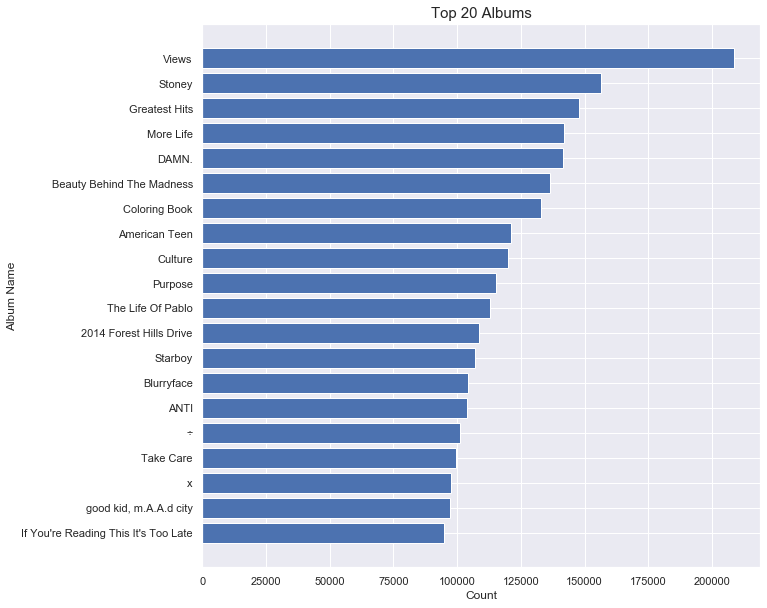

In [18]:
plt.figure(figsize=(10,10))
topAlbums = sorted_album[:20]
topAlbums.reverse()
topAlbums_names = [x[0] for x in topAlbums]
numbered = np.arange(len(topAlbums_names))
topAlbums_values = [x[1] for x in topAlbums]
plt.barh(numbered, topAlbums_values, align='center')
plt.yticks(numbered, topAlbums_names)
plt.xlabel("Count")
plt.ylabel("Album Name")
plt.title("Top 20 Albums", size=15)
plt.show()